In [51]:
from src.load_datasets import load_train_data
from src.evaluate_regression import custom_cross_validated_indices, custom_train_test_split, get_rankings, average_spearman
from src.meta_information import add_dataset_meta_information
from src.encoding import poincare_encoding, ohe_encode_train_data, ohe_encode_test_data
from src.feature_engineering import normalize_train_data, normalize_test_data
from src.modelling import train_model, make_prediction


import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [62]:
# figure settings
# settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()
sns.set(style='whitegrid', )
sns.set_palette(palette="Set2")
#sns.set_palette(palette="Paired")

# set seed
np.random.seed(7)

In [3]:
# Constants for supervisors functions
FACTORS = ["dataset", "model", "tuning", "scoring"]
NEW_INDEX = "encoder"
TARGET = "cv_score"

# Data

In [4]:
X_train, y_train = load_train_data('../../data/raw/dataset_train.csv')
# Add holdout set
X_train, X_holdout, y_train, y_holdout = custom_train_test_split(pd.concat([X_train, y_train], axis=1), FACTORS, TARGET)

Loading train data ...


In [5]:
df_holdout = pd.concat([X_holdout, y_holdout], axis=1)
df_train = pd.concat([X_train, y_train], axis=1)

In [6]:
# Keep a copy of the clean data
X_train_clean = X_train.copy()
X_holdout_clean = X_holdout.copy()

In [7]:
indices = custom_cross_validated_indices(df_train, FACTORS, TARGET, n_splits=5, shuffle=True, random_state=42)

# Preprocessing

In [8]:
# General encodings: One Hot Encode (OHE) subset of features (["model", "tuning", "scoring"])
X_train, ohe = ohe_encode_train_data(X_train=X_train,
                                     cols_to_encode=["model", "tuning", "scoring"],
                                     verbosity=2)
X_holdout = ohe_encode_test_data(X_test=X_holdout,
                                      cols_to_encode=["model", "tuning", "scoring"],
                                      ohe=ohe,
                                      verbosity=2)

One Hot Encoding the features ['model', 'tuning', 'scoring'] of the train data ...
One Hot Encoding the features ['model', 'tuning', 'scoring'] of the test data ...


In [9]:
# encode 'encoder'
X_train, _ = poincare_encoding(path_to_graph="../../data/raw/graph.adjlist",
                               path_to_embeddings="../../data/preprocessed/embeddings.csv",
                               data=X_train,
                               column_to_encode="encoder",
                               encode_dim=50,
                               explode_dim=True,
                               epochs=5000,
                               dim_reduction=False,
                               verbosity=2)
X_holdout, _ = poincare_encoding(path_to_embeddings="../../data/preprocessed/embeddings.csv",
                                 data=X_holdout,
                                 column_to_encode="encoder",
                                 encode_dim=50,
                                 explode_dim=True,
                                 epochs=5000,
                                 dim_reduction=False,
                                 verbosity=2)

(Poincare) Embedding the graph ...
Saving the embeddings to '../../data/preprocessed/embeddings.csv'...
Encoding the data feature 'encoder'...
Loading the embeddings from '../../data/preprocessed/embeddings.csv'...
Encoding the data feature 'encoder'...


In [10]:
# encode 'dataset'
X_train = add_dataset_meta_information(df=X_train,
                                       path_to_meta_df="../../data/preprocessed/dataset_agg.csv",
                                       nan_threshold=0.4,
                                       replacing_strategy="mean")
X_holdout = add_dataset_meta_information(df=X_holdout,
                                         path_to_meta_df="../../data/preprocessed/dataset_agg.csv",
                                         nan_threshold=0.4,
                                         replacing_strategy="mean")

In [11]:
# normalization
X_train, scaler = normalize_train_data(X_train=X_train, method='minmax', verbosity=2)
X_holdout = normalize_test_data(X_test=X_holdout, scaler=scaler, verbosity=2)

Normalizing train data using method 'minmax' ...
Normalizing test data ...


In [15]:
indices

[[Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                  9,
              ...
              21620, 21621, 21622, 21623, 21624, 21625, 21626, 21627, 21628,
              21629],
             dtype='int64', length=21630),
  Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
              ...
              5349, 5350, 5351, 5352, 5353, 5354, 5355, 5356, 5357, 5358],
             dtype='int64', length=5359)],
 [Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                  9,
              ...
              21513, 21514, 21515, 21516, 21517, 21518, 21519, 21520, 21521,
              21522],
             dtype='int64', length=21523),
  Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
              ...
              5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465],
             dtype='int64', length=5466)],
 [Int64Index([    0,     1,     2,     3,     4,     5,     6,  

# Train and Predict
Test a bunch of models with default parameters and compare them on the cv results as well as the holdout set.

**Case 1: All in All**
* ALL features included (encoded originals + meta features)
* ALL features encoded
    * model, tuning, scoring: OHE
    * encoder: poincare embedding (original column dropped)
    * dataset: meta features (original column minmax normalized)

In [73]:
k = 3

In [74]:
# Perform CV and train model on different models
results = {}
for m_name in ["DecisionTree", "RandomForest", "XGBoost", "CatBoost", "LinearRegression"]:
    print(f'####### {m_name} #######')
    # get cv results
    model, cv_result = train_model(model=m_name,
                                   train_data=X_train,
                                   train_labels=y_train,
                                   hyperparam_grid=None,
                                   verbosity=2,
                                   k_fold=k,
                                   indices=indices)
    # predict
    y_pred_holdout = make_prediction(model=model, test_data=X_holdout, save_data=False, verbosity=2)
    # get holdout results
    df_pred = pd.concat([X_holdout_clean, y_holdout, y_pred_holdout], axis=1)
    rankings_test = get_rankings(df_pred, factors=FACTORS, new_index=NEW_INDEX, target="cv_score")
    rankings_pred = get_rankings(df_pred, factors=FACTORS, new_index=NEW_INDEX, target="cv_score_pred")
    avg_spearman = average_spearman(rankings_test, rankings_pred)
    print(f"Average Spearman of holdout set: {avg_spearman:.4f} \n")

    # add to results
    results[m_name] = {}
    results[m_name]["cv_results"] = cv_result
    results[m_name]["houldout_set"] = avg_spearman

####### DecisionTree #######
Performing CV with 3 folds ...
Fitting final model (DecisionTree) ...

CV Training spearman: nan +/- nan 
CV Test spearman: nan +/- nan
CV Training neg_mean_squared_error: -0.0 +/- 0.0 
CV Test neg_mean_squared_error: -0.0 +/- 0.0
CV Training r2: 1.0 +/- 0.0 
CV Test r2: 1.0 +/- 0.0

Average Spearman of holdout set: 0.5230 

####### RandomForest #######
Performing CV with 3 folds ...
Fitting final model (RandomForest) ...

CV Training spearman: nan +/- nan 
CV Test spearman: nan +/- nan
CV Training neg_mean_squared_error: -0.0002 +/- 0.0 
CV Test neg_mean_squared_error: -0.0002 +/- 0.0
CV Training r2: 0.9963 +/- 0.0 
CV Test r2: 0.9958 +/- 0.0

Average Spearman of holdout set: 0.5472 

####### XGBoost #######
Performing CV with 3 folds ...
Fitting final model (XGBoost) ...

CV Training spearman: nan +/- nan 
CV Test spearman: nan +/- nan
CV Training neg_mean_squared_error: -0.0007 +/- 0.0 
CV Test neg_mean_squared_error: -0.0007 +/- 0.0
CV Training r2: 0.98

In [75]:
# cv_results and holdout set results in dfs
all_cv_results_df = pd.DataFrame()
all_holdout_results_df = pd.DataFrame()
for m_name in results.keys():
    # cv results
    cv_results_df = pd.DataFrame(results[m_name]["cv_results"])
    cv_results_df["model"] = m_name
    all_cv_results_df = pd.concat([all_cv_results_df, cv_results_df], axis=0).reset_index(drop=True)
    # holdout results
    holdout_results_df = pd.DataFrame({"model": m_name,
                                       "average_spearmen": results[m_name]["houldout_set"]}, index=[0])
    all_holdout_results_df = pd.concat([all_holdout_results_df, holdout_results_df], axis=0).reset_index(drop=True)

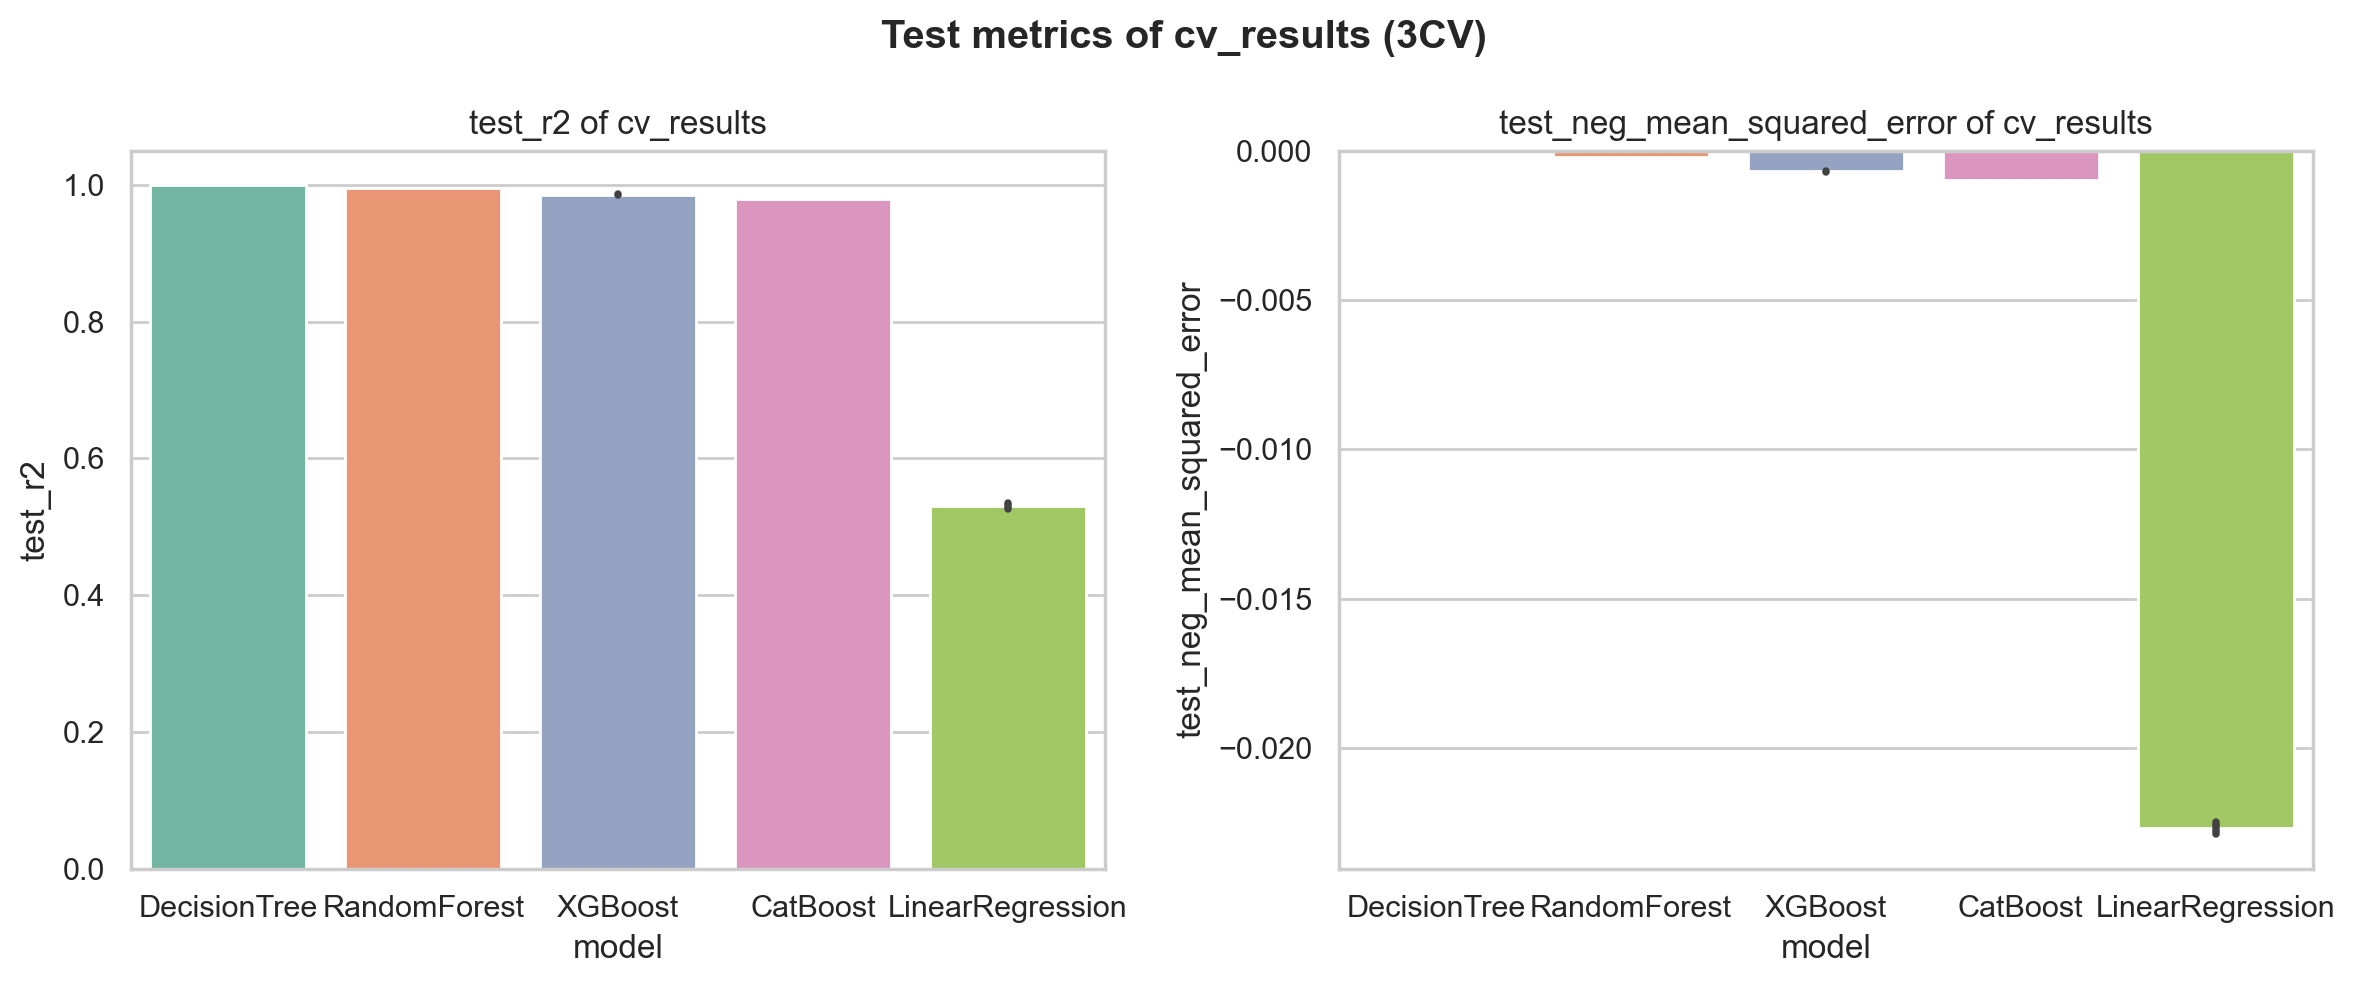

In [76]:
# plot test metrics of cv_results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x="model", y="test_r2", data=all_cv_results_df, ax=ax[0])
ax[0].set_title("test_r2 of cv_results")

sns.barplot(x="model", y="test_neg_mean_squared_error", data=all_cv_results_df, ax=ax[1])
ax[1].set_title("test_neg_mean_squared_error of cv_results")

fig.suptitle(f"Test metrics of cv_results ({k}CV)", fontweight="bold")

plt.tight_layout()
plt.show()

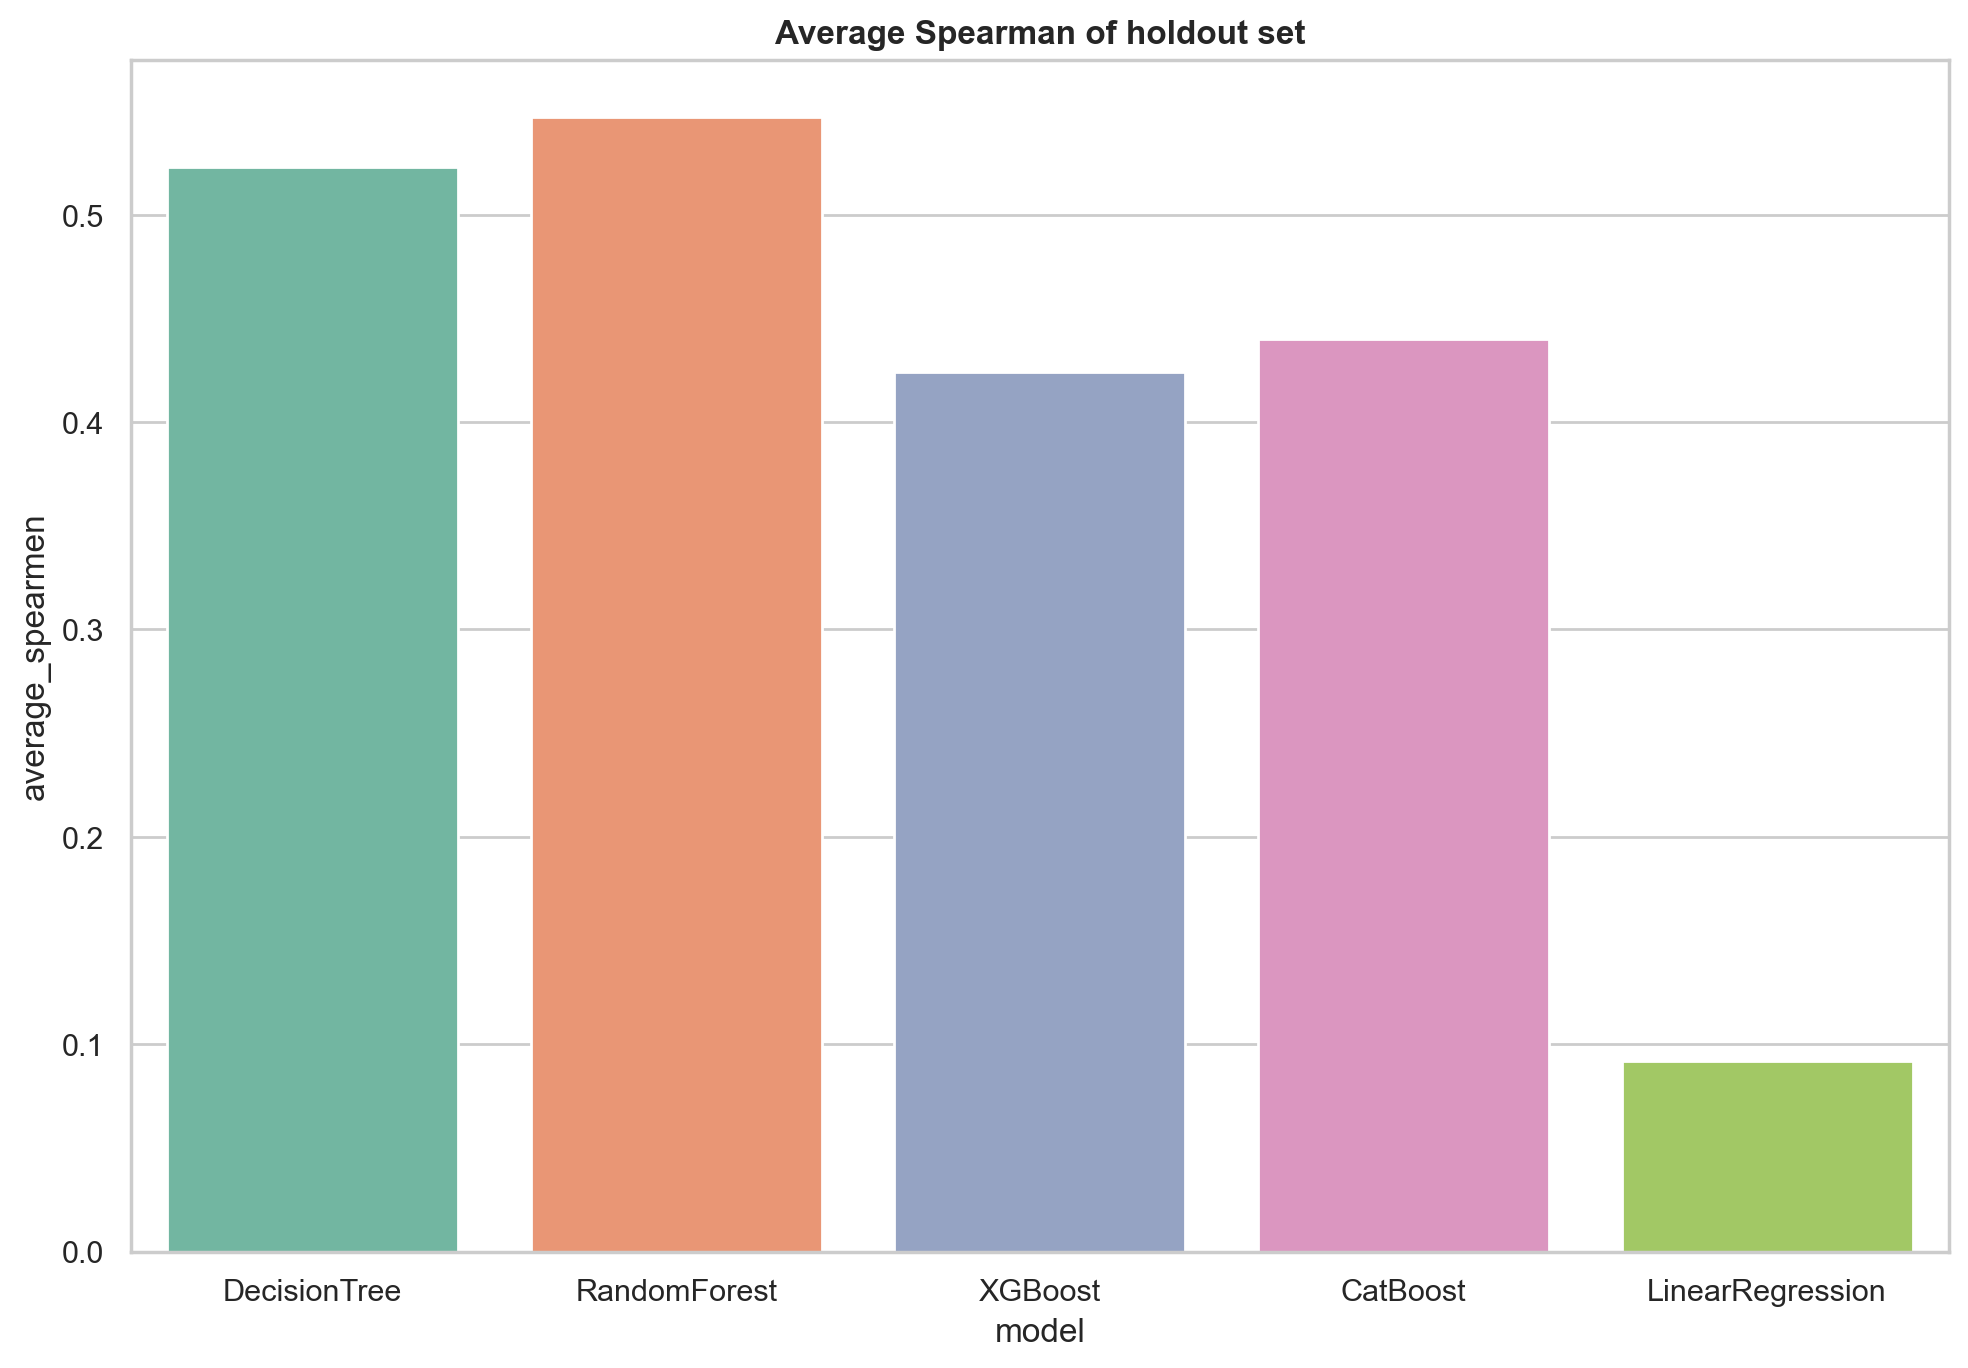

In [77]:
# plot holdout results
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

sns.barplot(x="model", y="average_spearmen", data=all_holdout_results_df, ax=ax)
ax.set_title("Average Spearman of holdout set", fontweight="bold")

plt.tight_layout()
plt.show()